# The HFM library - A fast marching solver with adaptive stencils

## Part : Custom optimal control models, discrete states
## Chapter : Elastica variants

$
\newcommand\bbone{\mathbb 1}\newcommand\bn{\mathbb n}\newcommand\sm{\setminus}
\newcommand\<{\langle}\newcommand\>{\rangle}
\newcommand\vp{\varphi}
\newcommand\diff{\mathrm d}
\DeclareMathOperator\Id{Id}\DeclareMathOperator\len{len}
\newcommand\kF{\mathfrak F}
\newcommand\cC{\mathcal C}\newcommand\cL{\mathcal L}\newcommand\cF{\mathcal F}\newcommand\cH{\mathcal H}
\newcommand\bB{\mathbb B}\newcommand\bM{\mathbb M}\newcommand\bQ{\mathbb Q}\newcommand\bR{\mathbb R}\newcommand\bS{\mathbb S}\newcommand\bZ{\mathbb Z}
$

In this notebook, we show how to customize the Euler Elastica model, as follows : 
- *Two independent implementations of the model*, using different representations of the Hamiltonian (max form, sum form).
- *A variant with a second state, where the vehicle rotates in place*
- *A variant which penalizes curvature variation*, rather than curvature.

This notebook also shows how to deeply customize the numerical scheme and models, which we hope will lead to the development of more even alternative models by the users. 

**Reminder on geodesic models and curvature penalization.**
Geodesic models look for a path $\gamma : [0,1] \to \bM$ minimizing the quantity
$$
\len_\cF^c(\gamma) := \int_0^1 c(\gamma(t)) \cF(\gamma(t),\gamma'(t)) \diff t,
$$
with fixed endpoints $\gamma(0),\gamma(1)\in\bM$, and where $c : \bM \to ]0,\infty]$ is a cost function.

In basic two-dimensional curvature penalized models, we assume that the manifold is $\bM := \bR^2 \times \bS^1$, and the metric takes the form 
$$
\cF(p,\dot p) := 
\begin{cases}
\cC(\dot \theta/|\dot x|) |\dot x| & \text{if } \dot x \propto \bn(\theta),\\
+\infty & \text{else},
\end{cases}
$$
for any $p=(x,\theta)\in \bM$ and any $\dot p = (\dot x,\dot \theta) \in \bR^2 \times \bR$ such that $|\dot x|\neq 0$. We denoted $\bn=(\cos \theta,\sin\theta)$.
Indeed, the manifold $\bM$ of interest is parallelizable, and the tangent space at each point can be canonically identified with $T_0\bM = \bR^2 \times \bR$.

If the curve has unit planar velocity $|\dot x|=1$, and obeys the non-holonomic constraint $\dot x \propto \bn(\theta)$, which means here that $\dot x$ is positively proportionnal to $\bn(\theta)$, then 
$$
\len\cF^c(\gamma) = \int_0^1 c(\gamma(t)) \cC(\dot \theta(t)) \diff t,
$$
is the integral of the product of a cost $c(\gamma(t))$ depending on the position, and a cost $\cC(\dot \theta(t))$depending on the curvature.


In this notebook, we focus on the Euler Elastica model, corresponding to the curvature dependent cost 
$$
\cC(\kappa) = 1+\kappa^2.
$$
An implementation of this model is provided in the agd library. Nevertheless, we show in this notebook how to re-implement in in two different ways, and to modify it.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Re-implementing the Euler elastica model](#1.-Re-implementing-the-Euler-elastica-model)
    * [1.1 Max form](#1.1-Max-form)
    * [1.2 Sum form](#1.2-Sum-form)
    * [1.3 Running the eikonal solver](#1.3-Running-the-eikonal-solver)
  * [2. Bounded curvature](#2.-Bounded-curvature)
    * [2.1 Max form](#2.1-Max-form)
    * [2.2 Sum form](#2.2-Sum-form)
    * [2.3 Running the eikonal solver](#2.3-Running-the-eikonal-solver)
  * [3. Introducing states](#3.-Introducing-states)
    * [3.1 Local direction changes](#3.1-Local-direction-changes)
    * [3.2 Reproducing the max form](#3.2-Reproducing-the-max-form)
  * [4. Penalization of curvature variation](#4.-Penalization-of-curvature-variation)
    * [4.1 Generating the controls](#4.1-Generating-the-controls)
    * [4.2 Running the eikonal solver](#4.2-Running-the-eikonal-solver)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [5]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('ElasticaVariants','FMM'))

In [3]:
from agd import Eikonal 
from agd import AutomaticDifferentiation as ad
from agd import Plotting
from agd import FiniteDifferences as fd
from agd.ExportedCode.Notebooks_FMM.DubinsState import control_source

In [3]:
import numpy as np
from matplotlib import pyplot as plt
π=np.pi

## 0.1 Additional configuration

**Running and viewing the notebook**
* *Static viewing.* If you are looking at this notebook using nbviewer, but see an error in the following cell, then [try this link instead](https://nbviewer.org/urls/www.dropbox.com/scl/fi/qk36i1efwxx5rif6n1bha/ElasticaVariants.ipynb/%3Frlkey%3Djskb6dnb0b103vtddjpom3e2f%26dl%3D1).
* *Running.* A cuda enabled GPU is needed to run this notebook. If you do not have one, try [running it on Google Colab](https://drive.google.com/open?id=1-ceaexLEVcaJFpS1fXoo4WQQBMhdvXAv&usp=drive_fs).

<!---
def reload_packages():
    from Miscellaneous.rreload import rreload
    global Eikonal
    Eikonal, = rreload([Eikonal],rootdir=sys.path[0])
    Eikonal.dictIn.default_mode = 'gpu_transfer'
--->

In [4]:
Eikonal.dictIn.default_mode = 'gpu_transfer'
try: import cupy
except ModuleNotFoundError: raise ad.DeliberateNotebookError("A cuda enabled gpu is required for this notebook")

## 1. Re-implementing the Euler elastica model

Our numerical implementation geodesic models relies on the HFM (Hamiltonian Fast Marching) principles, which requires approximating the Hamiltonian of the system as a max-of-sums-of-squares of finite differences, see below.

Recall that the *dual metric* $\cF^*$ and the *Hamiltonian* $\cH$ are defined in terms of the metric $\cF$ of a geodesic model as
\begin{align*}
\cF^*(p,\hat p) &= \sup\{\<\hat p, \dot p\>\mid \cF(p,\dot p) \leq 1\},&
\cH(p,\hat p) &= \tfrac 1 2 \cF^*(p,\hat p),
\end{align*}
for any point $p\in \bM$ and any co-vector $\hat p\in \bR^2\times \bR$. The (generalized, anisotropic) eikonal PDE, which is at the foundation of our shortest path solver, characterizes the arrival times $u$, of a front originating e.g. from part of the boundary of a domain $\Omega$, as the viscosity solution of $\cF^*(p, \nabla u(p))=1$, or equivalently 
$$
\cH(p,\nabla u(p))=\frac 1 2,
$$
for all $p \in \Omega$,
with suitable boundary conditions on $\partial \Omega$.

In the special case of the Elastical model, we find based on the description in the introduction that  
\begin{align*}
\cF(p,\dot p) & = \begin{cases}
|\dot x|+\dot \theta^2/|\dot x| & \text{if } x \propto \bn(\theta),\\
+\infty & \text{else}.
\end{cases} &
\cF^*(p,\hat p) &= \tfrac 1 2 \Big(\hat x + \sqrt{\hat x^2+\hat \theta^2}\Big).
\end{align*}

### 1.1 Max form

This numerical approach to eikonal PDE discretization requires a representation or an approximation of the Hamiltonian of the model under the form
$$
\cH_{\max}(p,\hat p) = 
\tfrac 1 2 \max_{1\leq i \leq I} \<\hat p,\omega_i(p)\>_+^2,
$$
where $(\omega_i)_{1\leq i \leq I}$ are vector fields over the domain $\bM$. Define the control set 
$$
\bB(p) := \{\dot p \mid \cF(p,\dot p)\leq 1\}.
$$
In view of the description of the dual-metric, it is natural to choose the vectors $(\omega_i(p))_{1\leq i\leq p}$ as a collection of (non-zero) extreme points of $\bB(p)$. 

In the special case of the Euler Elastica model, one can check based on the above expression of $\cF$ that 
$$
\bB(p) = \{(\dot s \bn(\theta),\dot \theta)\mid (\dot s-\tfrac 1 2)^2+\dot \theta^2 \leq \tfrac 1 4\}.
$$
In other words, $\bB$ is a flat disk of radius $1/2$ and centered at $(\bn(\theta)/2,0)$, contained within the plane $\bR (\bn(\theta),0) + \bR(0,1)$.

In [6]:
def elastica_control(ϕ): 
    """
    Control for the elastica model (two dimensional projection).
    Boundary point of the disk of radius 1/2 and center (1/2,0).
    """
    return np.cos(ϕ)*np.array((np.cos(ϕ),np.sin(ϕ)))

def elastica_controls(I,ϕmin=-π/2,ϕmax=π/2,pad=False):
    """
    Controls for the elastica model, regularly sampled.
    - I : number of controls
    - ϕmin, ϕmax : smallest and largest control
    - pad : add a zero control.
    """
    if ϕmin==-π/2: ϕmin = -π/2+π/I
    if ϕmax== π/2: ϕmax =  π/2-π/I
    ϕ=np.linspace(ϕmin,ϕmax,I)
    if pad: ϕ = np.pad(ϕ,(1,1),constant_values=π/2)
    return elastica_control(ϕ)

Note that "zero" controls are useless for the numerical scheme, and the irrelevant from the theoretical standpoint, but they sometimes help with the visualisation. Here is the approximation of the disk of controls that we obtain.

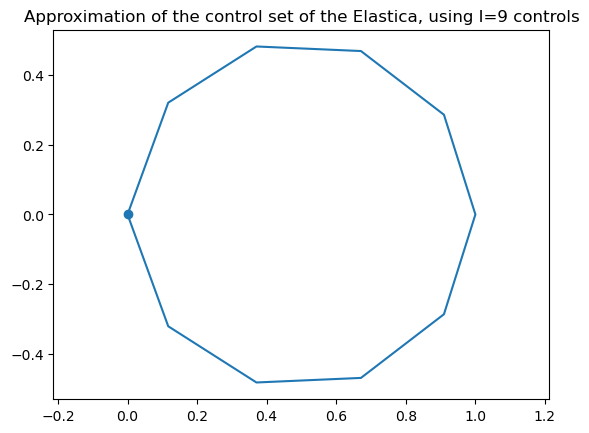

In [7]:
I=9
plt.title(f"Approximation of the control set of the Elastica, using {I=} controls")
plt.plot( *elastica_controls(I,pad=True) )
plt.scatter(0,0)
plt.axis('equal');

In some applications, one wants to vary the strength of the curvature penalization, or introduce some bias. This can be achieved by introducing parameters in the curvature cost function, defining 
$$
\tilde \cC(\dot \theta) := \cC(\xi (\dot \theta-\kappa)),
$$
where $\xi$ is a reference turning radius, and $\kappa$ is a reference curvature.
The metric and control set are modified accordingly
\begin{align*}
\tilde \cF(p,\dot p) = \dot s \tilde \cC(\dot \theta/\dot s) = \dot s \cC(\xi (\dot \theta-\kappa \dot s) / \dot s) = \cF(p, (\dot s\bn(\theta),\xi (\dot \theta-\kappa \dot s))) = \cF(p,A \dot p),
\end{align*}
where $p=(x,\theta)$ and $\dot p = (\dot s \bn(\theta),\dot \theta)$ with $\dot s > 0$ (if $\dot x$ is nonzero and not of the form $\dot s \bn(\theta)$, then the quantities are infinite). 

The matrix $A$ above, in the basis $(\bn(\theta),0),(\bn(\theta)^\perp,0),(0,1)$ of the tangent space $\bR^2 \times \bR$, has the following expression
$$
A = \begin{pmatrix}
1 \\
& 1 \\
-\xi\kappa & & \xi
\end{pmatrix}
$$

In terms of control set, we have by composition 
$$
\tilde \bB(p) = A^{-1} \bB(p) = \{(\dot s \bn(\theta),\dot \theta/\xi +\kappa \dot s)\mid (\dot s-\tfrac 1 2)^2+\dot \theta^2=\tfrac 1 4\}.
$$

In [8]:
def with_prior(c,ξ=1,κ=0):
    """
    Adjusts the control vectors to account for the following priors : 
    - ξ the typical turning radius, 
    - κ the reference curvature.
    """
    ds,dθ = c
    return np.array((ds,(dθ/ξ+κ*ds)))

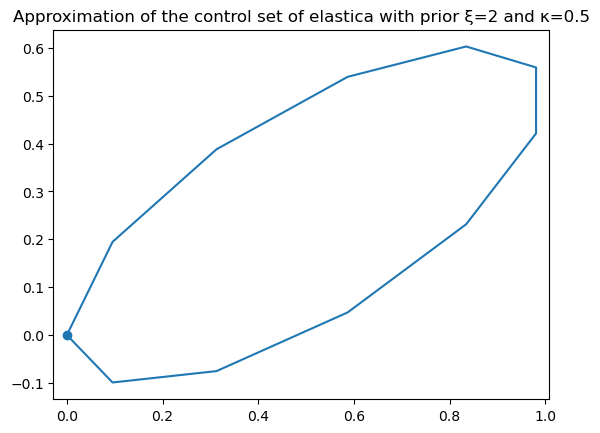

In [9]:
I=10;ξ=2;κ=0.5
plt.title(f"Approximation of the control set of elastica with prior {ξ=} and {κ=}")
plt.plot( *with_prior(elastica_controls(I,pad=True),ξ,κ) )
plt.scatter(0,0)
plt.axis('equal');

Finally, we map the controls into the plane $\bR(\bn(\theta),0)\oplus\bR(0,1) \subset \bR^2\times \bR$. 

In [10]:
def embed(c,θ):
    """
    Embed a two dimensional control (α,β) in R^2xR as (α n(θ),β)
    where n(θ) = (cos θ, sin θ)
    """
    ds,dθ = c
    return np.array((ds*np.cos(θ),ds*np.sin(θ),dθ*np.ones_like(θ)))

### 1.2 Sum form

This numerical approach to eikonal PDE discretization requires a representation or an approximation of the Hamiltonian in the form
$$
\cH(p,\hat p) = \frac 1 2 \sum_{1\leq i\leq I} \<\hat p,\omega_i(x)\>_+^2.
$$
The Hamiltonian of the Euler-Elastica model happens to admits an integral representation
$$
\cH(p,\hat p) = \frac 3 8 \int_{-\pi/2}^{\pi/2} \< \hat p, \bn(\theta,\phi)\>_+^2 \cos(\phi) \diff \phi,
$$
where $\bn(\theta,\phi) = (\cos\theta \cos \phi,\sin\theta\cos\phi,\sin\phi)$.
We can approximate this integral with a finite sum using the approximation
$$
    \int_{-\pi/2}^{\pi/2} f(\phi) \cos \phi \,  \diff \phi = \sum_{0 \leq k < K} w_k f(\phi_k) 
$$
where $\phi_k = (k+1/2) \pi/K - \pi/2$.
The optimal weights $w_k$, in terms of consistency order and over the full interval $[-\pi/2,\pi/2]$, are known as the Fejer weights.

In [11]:
fejer_weights_ = [
    [],[2.],[1.,1.],[0.444444, 1.11111, 0.444444],[0.264298, 0.735702, 0.735702, 0.264298],
    [0.167781, 0.525552, 0.613333, 0.525552, 0.167781],[.118661, 0.377778, 0.503561, 0.503561, 0.377778, 0.118661],
    [.0867162, 0.287831, 0.398242, 0.454422, 0.398242, 0.287831, 0.0867162],
    [.0669829, 0.222988, 0.324153, 0.385877, 0.385877, 0.324153, 0.222988, 0.0669829],
    [.0527366, 0.179189, 0.264037, 0.330845, 0.346384, 0.330845, 0.264037, 0.179189, 0.0527366]
]
def fejer_weights(I):
    """
    Returns the Fejer weights, for computing a cosine weighted integral.
    If I>=10, returns an approximation based on the midpoint rule.
    """
    if I<len(fejer_weights_): return fejer_weights_[I]
    x=np.linspace(0,π,I,endpoint=False)
    return np.cos(x)-np.cos(x+π/I)

In [12]:
def elastica_terms(I,ϕmin=-π/2,ϕmax=π/2):
    midpoints = Eikonal.CenteredLinspace(ϕmin,ϕmax,I)
    weights = np.array(fejer_weights(I))
    return np.array((np.cos(midpoints),np.sin(midpoints)))*np.sqrt((3/4)*weights)

In [13]:
elastica_terms(5)

array([[ 0.10961863,  0.50792095,  0.67823281,  0.50792095,  0.10961863],
       [-0.33737146, -0.36902617,  0.        ,  0.36902617,  0.33737146]])

In order to check this implementation of the Hamiltonian, we recall the identity
$$
    \cF(p, \nabla_{\hat p}\cF^*(p,\hat p)) = 1.
$$
Hence, by differentiating $\cF^*(p,\cdot) = \sqrt{2 \cH(p,\cdot)}$, we should recover the boundary of the control set $\bB(p)$.

In [14]:
def Fstar(dp,w):
    """Dual metric F^*(dp) = sqrt{sum_i <dp,w_i>_+^2}, from the integral representation by (w_i)_{1<=i<=I}"""
    return np.sqrt(np.sum(np.maximum(0,np.sum(w*dp,axis=0))**2,axis=0))

def ball(w,n=500):
    """
    Compute the boundary of the control set, when the Hamiltonian is described as 
    sum_i <p,w_i>_+^2
    """
    ϵ=1e-3; ϕ = np.linspace(-π+ϵ,π-ϵ,n) 
    dp = np.array((np.cos(ϕ),np.sin(ϕ)))
    dp_ad = ad.Dense.identity(constant=dp,shape_free=(2,))
    
    Fstar_ad = Fstar(dp_ad[:,None,:],w[:,:,None])
    vecs = Fstar_ad.gradient() 
    vecs[np.isnan(vecs)]=0 # NaN when differentiating sqrt(0).
    return vecs #np.pad(vecs,((1,1),(0,0)),constant=0)

Two observations :
- The difference between the Fejer weights and the midpoint weights is minimal.
- The shape is much closer to being circular (which is the correct elastica model) than with the max representation.

C:\Users\jmmir\Documents\GitHub\AdaptiveGridDiscretizations\Notebooks_FMM\../../AdaptiveGridDiscretizations\agd\AutomaticDifferentiation\Base.py:24: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1))
C:\Users\jmmir\Documents\GitHub\AdaptiveGridDiscretizations\Notebooks_FMM\../../AdaptiveGridDiscretizations\agd\AutomaticDifferentiation\Dense.py:94: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef)


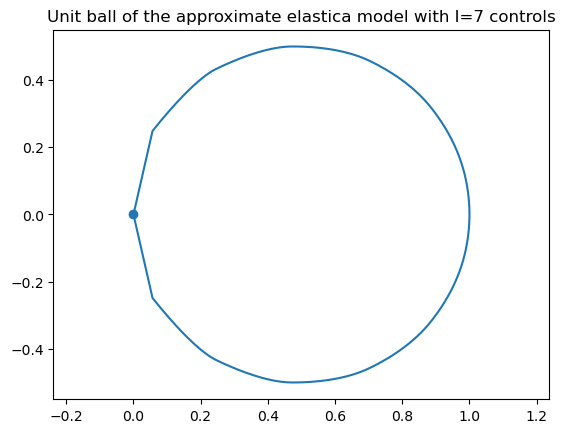

In [15]:
I=7
plt.title(f"Unit ball of the approximate elastica model with {I=} controls")
plt.plot(*ball(elastica_terms(I)))
plt.scatter(0,0); plt.axis('equal');

In the following variant of the elastica model, we only allow turning left, so as to delineate convex shapes. 

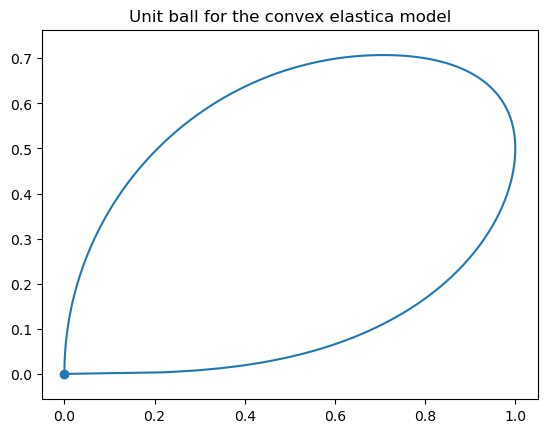

In [16]:
plt.title("Unit ball for the convex elastica model")
plt.plot(*ball(np.abs(elastica_terms(I=100))))
plt.scatter(0,0)
plt.axis('equal');

In the next variant, we modify the typical turning radius and reference curvature.

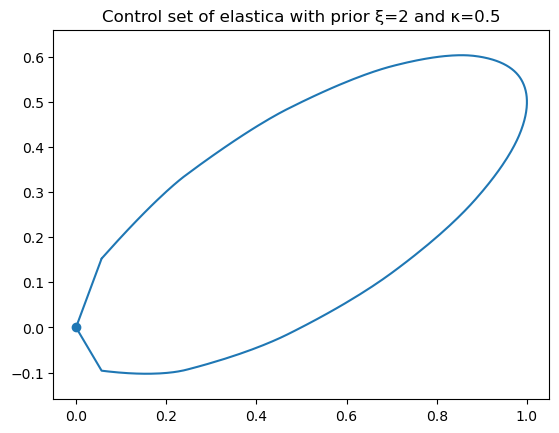

In [17]:
ξ=2;κ=0.5
plt.title(f"Control set of elastica with prior {ξ=} and {κ=}")
plt.plot(*ball(with_prior(elastica_terms(I=7),ξ,κ)));
plt.scatter(0,0); plt.axis('equal');

### 1.3 Running the eikonal solver

First, we choose a domain, within which to compute geodesics. This domain is three dimensional, with two space dimensions and one angular dimension.

In [18]:
# A two dimensional array representing the walls
walls = np.array(0==Plotting.imread('Notebooks_FMM/TestImages/PompidouCrop.png').T,dtype=bool)
# Number of orientations
Nθ = 64

We then setup the eikonal solver. For reference, we first run the default implementation of the Euler elastica model, already present in the AGD library.

In [19]:
elasticaIn = Eikonal.dictIn({
    'model':'Elastica2',
    'speed':1,
    'xi':1, # Typical turning radius
    'kappa':0, # (Optional) Asymmetric curvature prior
    'seed':(1,5,1.),
    'tips':[[13,15,0],[19,14,0],[12,12,0],[17,5,0],[7,2,-3],[3,13,-1.5]],
    'dims':(*walls.shape, Nθ),
    'walls':walls,
    'gridScale':0.1,
    'origin':(0,0),
    'exportValues':True
})

In [20]:
aX0,aX1,Θ = elasticaIn.Axes()
X = np.meshgrid(aX0,aX1,indexing='ij')

The physical domain, seed (start of front propagation) and tips (start of geodesic backtracking process).

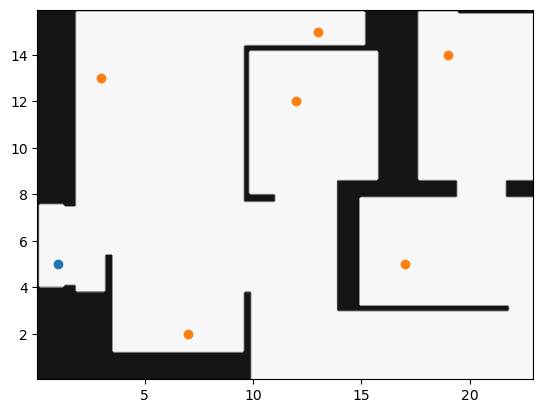

In [21]:
plt.contourf(*X,walls,cmap='Greys')
plt.scatter(*elasticaIn['seed'][:2])
plt.scatter(*elasticaIn['tips'].T[:2]);

In [22]:
elasticaOut = elasticaIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.34816884994506836 seconds, and 373 iterations.
Post-Processing


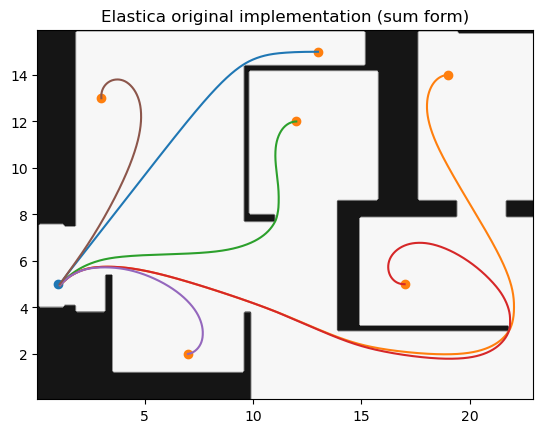

In [23]:
plt.title("Elastica original implementation (sum form)")
plt.contourf(*X,walls,cmap='Greys')
plt.scatter(*elasticaIn['seed'][:2])
plt.scatter(*elasticaIn['tips'].T[:2]);
for geo in elasticaOut['geodesics']: plt.plot(*geo[:2])

We reproduce these results using the model `DubinsState4` which features three physical dimensions and one additional dimension for states. The latter is not used here. We start with the sum form implementation of the Hamiltonian, which should be identical to the reference implementation.

In [24]:
sumIn = Eikonal.dictIn({
    'model':'Custom3',
    'speed':1,
    'seed':elasticaIn['seed'],
    'tips':elasticaIn['tips'],
    'dims':elasticaIn['dims'],
    'origin':(0,0, -np.pi/Nθ),
    'gridScales':elasticaIn.gridScales,
    'periodic':[False,False,True], # Domain = R^2 x S^1
    'traits':{'controls_max_macro':False},
    'exportValues':True,
})
sumIn['walls'] = np.broadcast_to(walls[:,:,np.newaxis],sumIn.shape)

In [25]:
controls = with_prior(elastica_terms(5),ξ=elasticaIn['xi'],κ=elasticaIn['kappa'])
sumIn['controls']=np.moveaxis(embed(controls,Θ[:,None]),-1,0)

Always check the controls shape, which must be : 
$$
    \text{number of controls} \times \text{physical space dimension} \times \text{last domain dimensions}.
$$

Here the domain has dimensions $N_x \times N_y\times N_\theta$. Only the last domain dimension is used in this example, namely $N_\theta$, since the control vectors do not depend on the physical coordinates $x$ and $y$.

In [26]:
sumIn['controls'].shape

(5, 3, 64)

In [27]:
sumOut = sumIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.6741752624511719 seconds, and 303 iterations.
Post-Processing


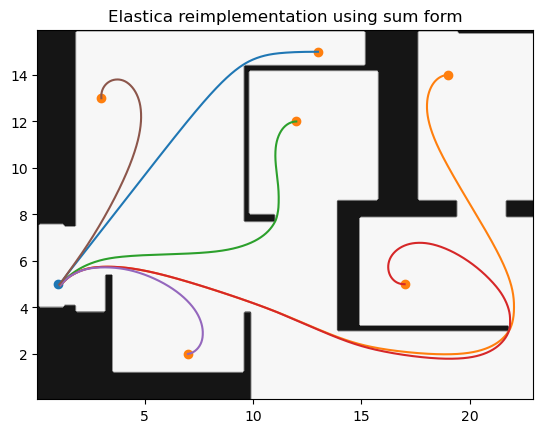

In [28]:
plt.title("Elastica reimplementation using sum form")
plt.contourf(*X,walls,cmap='Greys')
plt.scatter(*sumIn['seed'][:2])
plt.scatter(*sumIn['tips'].T[:2]);
for geo in sumOut['geodesics']: plt.plot(*geo[:2])

As discussed above, the AGD eikonal solver uses the sum representation of the Elastica Hamiltonian to compute shortest paths.
As a result, the numerical solution obtained is identical, up to machine precision, up to a slight difference : 
the multiplicative factor $\sqrt{3/4}$ is omitted in the AGD library. 

In [29]:
assert np.nanmax(np.abs(np.sqrt(3/4)*sumOut['values']-elasticaOut['values'])) < 2e-4

C:\Users\jmmir\AppData\Local\Temp\ipykernel_112532\2148432906.py:1: RuntimeWarning: invalid value encountered in subtract
  assert np.nanmax(np.abs(np.sqrt(3/4)*sumOut['values']-elasticaOut['values'])) < 2e-4


We now turn to the max implementation of the elastica model.

In [30]:
maxIn = sumIn.copy()
maxIn.pop('traits') # 'controls_max_macro':True is the default.

{'controls_max_macro': False}

Define the max controls, as described above, and check the shape.

In [31]:
controls = with_prior(elastica_controls(9),ξ=elasticaIn['xi'],κ=elasticaIn['kappa'])
maxIn['controls']=np.moveaxis(embed(controls,Θ[:,None]),-1,0)

In [32]:
maxIn['controls'].shape

(9, 3, 64)

In [33]:
maxOut = maxIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.5393521785736084 seconds, and 237 iterations.
Post-Processing


The numerical results are reasonnable but we can see that the max form, in comparison with the sum form, requires a larger number of controls to achieve the same smoothness of paths (9 instead of 5) here. 

In fact, the paths obtained with the max form should be, from the theoretical standpoint, piecewise linear (with usually as many orientations as available controls).

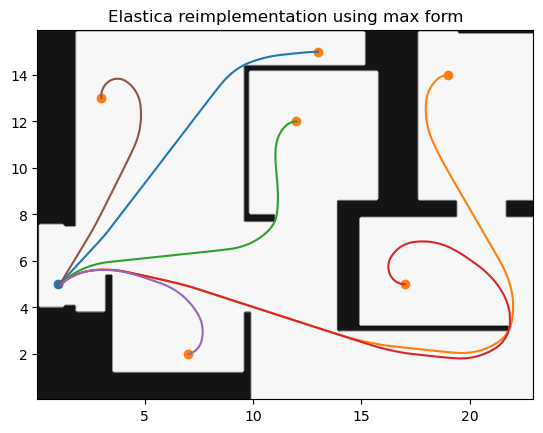

In [34]:
plt.title("Elastica reimplementation using max form")
plt.contourf(*X,walls,cmap='Greys')
plt.scatter(*sumIn['seed'][:2])
plt.scatter(*sumIn['tips'].T[:2]);
for geo in maxOut['geodesics']: plt.plot(*geo[:2])

The agreement between the two numerical schemes is reasonnable, given that the problem is rather degenerate and has a discontinuous solution.

<!---
meanval = np.mean(elasticaOut['values'][np.isfinite(elasticaOut['values'])])
close = elasticaOut['values']<meanval 
error = np.where(close, np.sqrt(3/4)*np.squeeze(maxOut['values'],-1)-elasticaOut['values'],np.nan)
np.nanmean(np.abs(error))
--->

In [35]:
np.nanmean(np.abs(np.sqrt(3/4)*maxOut['values']-elasticaOut['values']))

C:\Users\jmmir\AppData\Local\Temp\ipykernel_112532\218061358.py:1: RuntimeWarning: invalid value encountered in subtract
  np.nanmean(np.abs(np.sqrt(3/4)*maxOut['values']-elasticaOut['values']))


1.6037367195886267

In [36]:
np.mean(elasticaOut['values'][np.isfinite(elasticaOut['values'])])

19.009001994973488

## 2. Bounded curvature

In some applications, one would like to bound the curvature of the path, above and below.
In other words to enforce:
$$
\frac {\dot \theta}{\dot s} \in ]\kappa_{\min},\kappa_{\max}[=]\tan\phi_{\min},\tan \phi_{\max}[,
$$
for some constants $-\infty\leq \kappa_{\min} \leq \kappa_{\max} \leq \infty$, equivalently $-\pi/2 \leq \phi_{\min} \leq \phi_{\max} \leq \pi/2$.

There are many ways to modify the model to achieve this behavior. 
We discuss in this section two natural approaches, based on the variants of the max-form and sum-form discussed above.

Note that, up to modifying the parameters $\xi$ and $\kappa$, we can assumme $\kappa_{\min}=\kappa_{\max}=1$.


### 2.1 Max form

One possible approach to achieve bounded curvature is to define the model through the modified metric
$$
    \tilde \cF(p, (\dot s \bn(\theta), \dot \theta)) = 
    \begin{cases}
        \dot s + \frac {\dot \theta^2} {\dot s} & \text{if } \kappa_{\min} \leq \dot \theta/\dot s \leq \kappa_{\max},\\
        +\infty &\text{else},
    \end{cases}
$$
where $p=(x,\theta)$, $\dot s>0$, $\dot \theta\in \bR$. The metric is still defined as $+\infty$ for planar velocities $\dot x$ which are not positively proportionnal with $\bn(\theta)$.

Equivalently, in terms of control set 
$$
    \tilde \bB(p) = \{ (\dot s \bn(\theta), \dot \theta) \mid (\dot s-\tfrac 1 2)^2 + \dot \theta^2\leq \tfrac 1 4,\  
    \kappa_{\min} \leq \dot \theta/\dot s \leq \kappa_{\max}\}.
$$
In order to implement this model, it is sufficient to choose a collection of extreme points of $\tilde \bB(p)$, whose convex hull approximates the whole set. This is illustrated below.

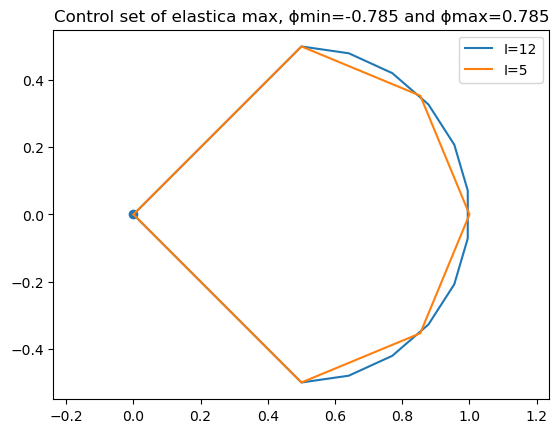

In [37]:
ϕmin=-π/4;ϕmax=π/4
plt.title(f"Control set of elastica max, {ϕmin=:.3f} and {ϕmax=:.3f}")
I=12; plt.plot(*elastica_controls(I,ϕmin,ϕmax,pad=True),label=f"{I=}")
I=5; plt.plot(*elastica_controls(I,ϕmin,ϕmax,pad=True),label=f"{I=}")
plt.legend()
plt.scatter(0,0); plt.axis('equal');

One negative aspect of this model is that the control set is not smooth. 
Therefore, the model will often behave very similarly to the Dubins model : on large portions of the optimal trajectory, the curvature may be constant and equal to $\kappa_{\min}$ or $\kappa_{\max}$. 

### 2.2 Sum form

Starting from the integral form of the Hamiltonian, a natural approach to bound the angles is to consider the variant
$$
\cH(p,\dot p) = \int_{\phi_{\min}}^{\phi_{\max}} \<\dot p, \bn(\theta,\phi)\>_+^2 w(\phi) \diff \phi,
$$
where $p = (x,\theta)$. 

One possible choice for the integral weight is
$$
w(\phi) = \frac 1 {\phi_\delta} \cos\big(\frac{\phi-\phi_{m}}{\phi_\delta}\big),
$$
where $\phi_m = (\phi_{\max}+\phi_{\min})/2$ and $\phi_\delta = (\phi_{\max}-\phi_{\min})/\pi$, which corresponds to a reparametrization of the cosine weight from the interval $[-\pi/2,\pi/2]$ to $[\phi_{\min},\phi_{\max}]$. 
With this choice, we can still use the Fejer weights for the discretization.

If one follows this approach, then the Hamiltonian remains smooth, as well as the control set.
The implementation requires discretizing the above integral, which we do using the midpoint rule.

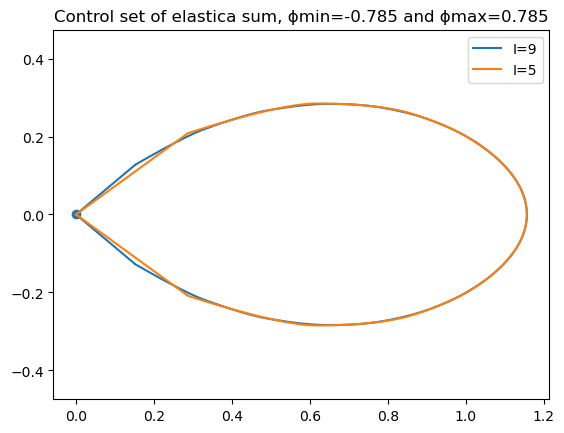

In [38]:
ϕmin=-π/4;ϕmax=π/4
plt.title(f"Control set of elastica sum, {ϕmin=:.3f} and {ϕmax=:.3f}")
I=9; plt.plot(*ball(elastica_terms(I,ϕmin,ϕmax)),label=f"{I=}");
I=5; plt.plot(*ball(elastica_terms(I,ϕmin,ϕmax)),label=f"{I=}");
plt.legend(); plt.scatter(0,0); plt.axis('equal');

Before running the models, let us compare their control sets.
We see that the sum form variant with bounded curvature is rather close to the original model with doubled $\xi$. 

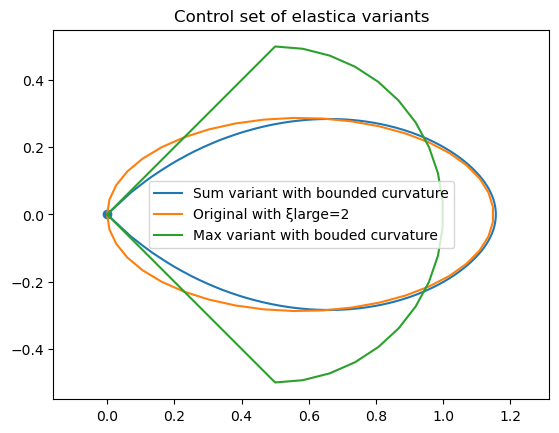

In [39]:
ϕmin=-π/4;ϕmax=π/4;ξlarge=2
plt.title(f"Control set of elastica variants")
I=20; plt.plot(*ball(elastica_terms(I,ϕmin,ϕmax)),label=f"Sum variant with bounded curvature");
I=40; plt.plot(*with_prior(1.15*elastica_controls(I,pad=True),ξ=ξlarge),label=f"Original with {ξlarge=}");
I=20; plt.plot(*elastica_controls(I,ϕmin,ϕmax,pad=True),label=f"Max variant with bouded curvature");
plt.legend(); plt.scatter(0,0); plt.axis('equal');

### 2.3 Running the eikonal solver

In [40]:
sumBdIn = sumIn.copy()
controls = with_prior(elastica_terms(5,ϕmin,ϕmax),ξ=elasticaIn['xi'],κ=elasticaIn['kappa'])
sumBdIn['controls']=np.moveaxis(embed(controls,Θ[:,None]),-1,0)

In [41]:
sumBdOut = sumBdIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.28753662109375 seconds, and 278 iterations.
Post-Processing


As expected, takes wider turns. It still has smooth trajectories, and the the model prevents the turning radius from ever going below $1$.

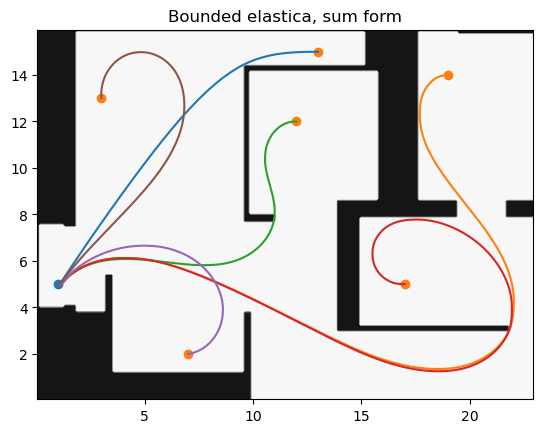

In [42]:
plt.title("Bounded elastica, sum form")
plt.contourf(*X,walls,cmap='Greys')
plt.scatter(*sumIn['seed'][:2])
plt.scatter(*sumIn['tips'].T[:2]);
for geo in sumBdOut['geodesics']: plt.plot(*geo[:2])

As discussed above with the control sets, we can expect rather similar curves by doubling $\xi$ on the original model.
Nevertheless, this offers no guarantee on the curvature radius lower bound, and we indeed see in some places smaller radius of cuvature. 

In [43]:
ξlarge = 2;
elasticaOut2 = elasticaIn.Run({"xi":ξlarge})

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.2705385684967041 seconds, and 340 iterations.
Post-Processing


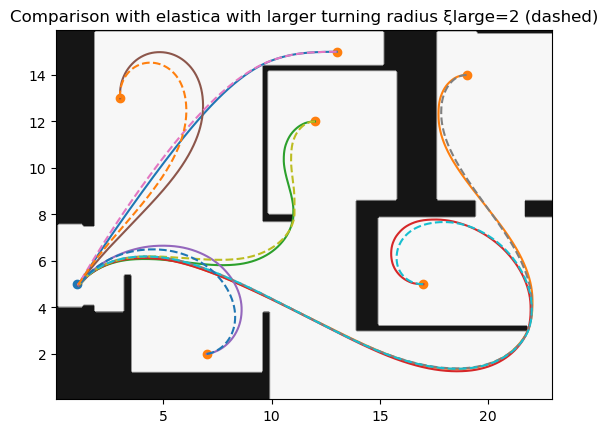

In [44]:
plt.title(f"Comparison with elastica with larger turning radius {ξlarge=} (dashed)")
plt.contourf(*X,walls,cmap='Greys')
plt.scatter(*sumIn['seed'][:2])
plt.scatter(*sumIn['tips'].T[:2]);
for geo in sumBdOut['geodesics']: plt.plot(*geo[:2])
for geo in elasticaOut2['geodesics']: plt.plot(*geo[:2],'--')

In [45]:
maxBdIn = maxIn.copy()
controls = with_prior(elastica_controls(9,ϕmin,ϕmax),ξ=elasticaIn['xi'],κ=elasticaIn['kappa'])
maxBdIn['controls']=np.moveaxis(embed(controls,Θ[:,None]),-1,0)

In [46]:
maxBdOut = maxBdIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.23302221298217773 seconds, and 238 iterations.
Post-Processing


This time, we compare the results with the original elastica model, without altering $\xi$.
The original trajectories whose turning radius was everywhere $\geq 1$ remain identical, which is expected.
The original trajectories which involved a small turning radius, at some point, are modified adequately.

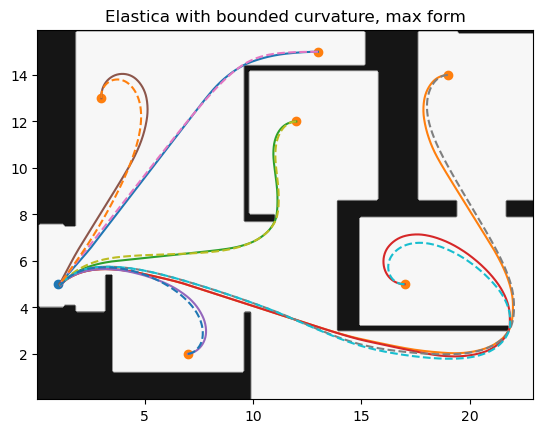

In [47]:
plt.title("Elastica with bounded curvature, max form")
plt.contourf(*X,walls,cmap='Greys')
plt.scatter(*sumIn['seed'][:2])
plt.scatter(*sumIn['tips'].T[:2]);
for geo in maxBdOut['geodesics']: plt.plot(*geo[:2])
for geo in elasticaOut['geodesics']: plt.plot(*geo[:2],'--')

## 3. Introducing states

A vehicle may switch to different behavior modes depending on the environnement. 
We can reproduce this behavior in the model by introducing different states.

### 3.1 Local direction changes

We consider a curvature penalized model which has two states:
- (Bounded curvature) This state requires the vehicle to move forward at all times, at positive speed. It can be implemented as an elastica model, a variant with e.g. bounded curvature, or a Dubins model.
- (In place rotation) This state allows the vehicle to perform in place rotations. It can be implemented as a Reeds-Shepp model, a variant such as the one with non-negative physical speed, or a model which only allows in place rotations.

The model can switch from one state to the other, which incurs a transition cost penalty. This may be done at places where a very localized maneuver is required. For instance at vessel bifurcations in the setting of retina vessel segmentation.

In practice we choose a bounded elastica model, and a model which only allows in place rotations.

In [48]:
def in_place_rotation_controls(): return np.array(((0,0,1),(0,0,-1)))
state_transition_base_cost = np.array(((0,1),(1,0))) # discrete cost of jumping from one state to another

In [49]:
# Elastica model with bounded curvature, max form
I=9; controls0 = with_prior(elastica_controls(I,ϕmin,ϕmax),ξ=elasticaIn['xi'])
controls0 = np.moveaxis(embed(controls0,Θ[:,None]),-1,0)

# In place rotation only
controls1 = in_place_rotation_controls()
controls1 = np.pad(controls1,((0,I-2),(0,0))) # Add some null controls (to match the other number)
controls1 = controls1[:,:,np.newaxis]+0.*Θ # No dependency w.r.t. Θ

# Combined controls
controls = np.stack([controls0,controls1],axis=-1)

Checking the shape of the controls : (Number of controls) x (physical dimension) x (last domain dimensions : $\Theta$ and states)

In [50]:
controls.shape

(9, 3, 64, 2)

In [51]:
nstates = controls.shape[-1]
stateIn = Eikonal.dictIn({
    'model':'DubinsState4',
    'speed':1,
    'seed':(*elasticaIn['seed'],0),
    'tips':[(*tip,0) for tip in elasticaIn['tips']],
    'dims':(*elasticaIn['dims'],nstates),
    'origin':(0,0, -np.pi/Nθ,-0.5),
    'gridScales':(*elasticaIn.gridScales,1),
    'periodic':[False,False,True,False], # Domain = R^2 x S^1 x States
    'exportValues':True,
    'exportActiveNeighs':True,
})
stateIn['walls'] = np.broadcast_to(walls[:,:,np.newaxis,np.newaxis],stateIn.shape)
stateIn['controls'] = controls

For reproducibility, we first put a high transition cost. In that case, the in-place-rotation mode will not be used.

In [52]:
stateOut=stateIn.Run({'state_transition_costs':100*state_transition_base_cost})

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.4411008358001709 seconds, and 309 iterations.
Post-Processing


In [53]:
valid = stateOut['values'][...,0]<100 # Points attained without in-place rotation in the path
assert np.allclose(stateOut['values'][...,0][valid],maxBdOut['values'][valid]) # Identical path cost

In [54]:
state_costs=[3,1,0.3] 
stateOuts=[stateIn.Run({'state_transition_costs':s*state_transition_base_cost}) for s in state_costs]

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.4246509075164795 seconds, and 309 iterations.
Post-Processing
Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.4100492000579834 seconds, and 313 iterations.
Post-Processing
Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.41104888916015625 seconds, and 322 iterations.
Post-Processing


As we vary the state transition cost, we can see the following behavior:
- (High transition cost) We recover the geodesics of the original model (elastica with bounded curvature, max implementation)
- (Medium transition cost) We often see a transition to the inplace rotation mode at the end of the curve, so as to facilitate the final maneuver.
- (Low transition cost) The path may transition to the inplace rotation when it has to go around a wall.

linestyle='-' with state transition cost 3
linestyle='--' with state transition cost 1
linestyle=':' with state transition cost 0.3


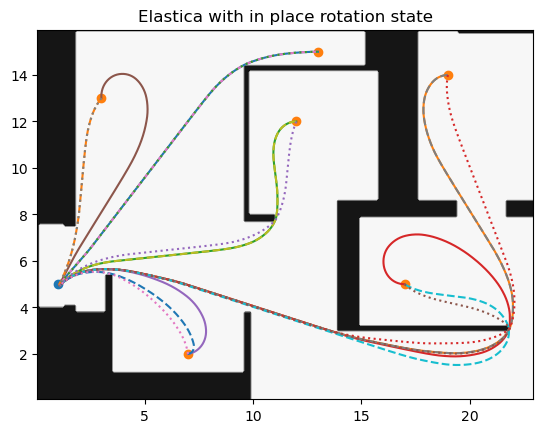

In [55]:
plt.title("Elastica with in place rotation state")
plt.contourf(*X,walls,cmap='Greys')
plt.scatter(*sumIn['seed'][:2])
plt.scatter(*sumIn['tips'].T[:2])
for (s,linestyle,hfmOut) in zip(state_costs,['-','--',':'],stateOuts):
    print(f"{linestyle=} with state transition cost {s}")
    for geo in hfmOut['geodesics']: plt.plot(*geo[:2],linestyle)

*Possible issues with backtracking.* In this example, when the *state transition cost is very low*, below $<0.05$, the geodesic backtracking often fails around *wall corners*. Namely, the geodesic enters the walls and stops there.

<!---
stateLowOut=stateIn.Run({'state_transition_costs':0.01*state_transition_base_cost})
print(stateLowOut['geodesic_stopping_criteria'])

plt.title("Elastica with bounded curvature, max form")
plt.contourf(*X,walls,cmap='Greys')
plt.scatter(*sumIn['seed'][:2])
plt.scatter(*sumIn['tips'].T[:2])
for geo in stateLowOut['geodesics']: plt.plot(*geo[:2])
--->

The `active_source` data obtained below indicates the places where jumping to the other state is favorable.

Jumping is performed when it is advantageous to perform an inplace rotation before the backtracking with the bounded curvature elastica model.
We observe that:
- With *low* transition costs, jumps to the in-place rotation state are common, as soon as the current orientation $\theta$ is not toward the seed.
- With *high* transition costs, jumps to the in-place rotation state are limited to places where a complex, or maybe unfeasible, maneuver would be needed for the bounded curvature model.

<!---
iθ = 10; θ = Θ[iθ];
plt.title(f"Places where jumping to in place rotation is favorable, {θ=:.2f}")
plt.contourf(*X,walls,cmap='Greys')
plt.contourf(*X,active_source[:,:,iθ,0]);
plt.scatter(*sumIn['seed'][:2])
plt.arrow(8,12,-np.cos(θ),-np.sin(θ),head_width=1); # Negative sign accounts for backtracking orientation
--->

In [56]:
_,active_source_high=control_source(stateOut['activeNeighs'],len(controls))
_,active_source_low=control_source(stateOuts[-1]['activeNeighs'],len(controls))

C:\Users\jmmir\Documents\GitHub\AdaptiveGridDiscretizations\Notebooks_FMM\../../AdaptiveGridDiscretizations\agd\ExportedCode\Notebooks_FMM\DubinsState.py:28: RuntimeWarning: divide by zero encountered in log2
  source = np.log2(active).round().astype(int) # source of the jump


Places where jumping to in place rotation is favorable, θ=0.98


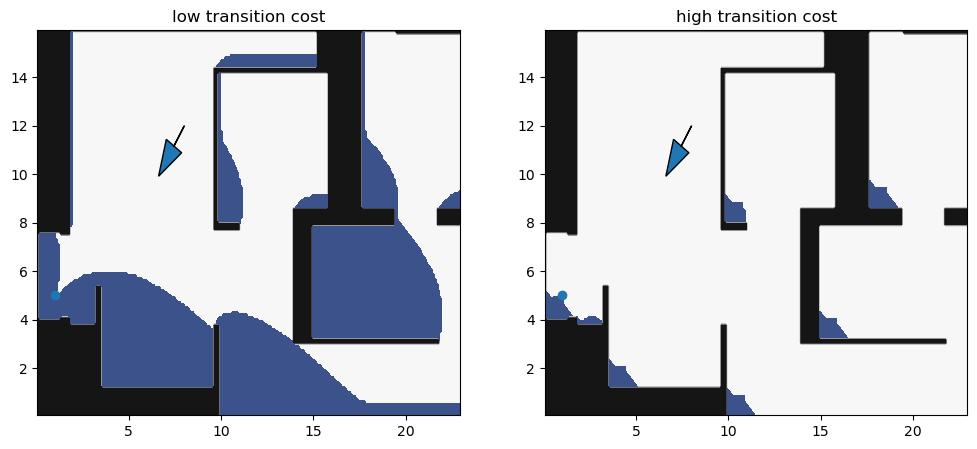

In [57]:
iθ = 10; θ = Θ[iθ];
print(f"Places where jumping to in place rotation is favorable, {θ=:.2f}")
plt.figure(figsize=(12,5))
for i,(caption,active_source_data) in enumerate([('low',active_source_low),('high',active_source_high)]):
    plt.subplot(1,2,i+1)
    plt.title(f"{caption} transition cost")
    plt.contourf(*X,walls,cmap='Greys')
    plt.contourf(*X,active_source_data[:,:,iθ,0]);
    plt.scatter(*sumIn['seed'][:2])
    plt.arrow(8,12,-np.cos(θ),-np.sin(θ),head_width=1); # Negative sign accounts for backtracking orientation

### 3.2 Reproducing the max form

In this experiment, we do not aim to generalize the model, but only to validate the implementation.

We introduce several states, with *very small transition costs* between them, and a single control vector for each of them. 
This model should reproduce the max form of the implementation of the Euler-Elastica model. 

In [58]:
I=7; nstates = I # For technical reasons, we are limited to 7 different states
controls = with_prior(elastica_controls(I),ξ=elasticaIn['xi'])
controls = embed(controls,Θ[:,None])[np.newaxis]

In [59]:
controls.shape

(1, 3, 64, 7)

In this implementation, we have $I$ distinct states, each of which has only one control, hence only the possibility of going forward in the corresponding direction. 

In [60]:
maxStateIn = stateIn.copy()
maxStateIn.update({
    'dims':(*elasticaIn.shape,nstates),
    'controls' : controls,
    'state_transition_costs':1e-10*np.ones((nstates,nstates)),
    'exportFlowState':True, # For validation
})
maxStateIn['walls']=np.broadcast_to(walls[:,:,np.newaxis,np.newaxis],maxStateIn.shape)

In [61]:
maxStateOut = maxStateIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.6741137504577637 seconds, and 348 iterations.
Post-Processing


Since we put an infinitesimal transition cost between states, then this amuonts to the max implementation of the elastica model.

In [62]:
maxRefIn = maxIn.copy()
controls = with_prior(elastica_controls(I),ξ=elasticaIn['xi'])
maxRefIn['controls']=np.moveaxis(embed(controls,Θ[:,None]),-1,0)

In [63]:
maxRefOut = maxRefIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.5410819053649902 seconds, and 236 iterations.
Post-Processing


In [64]:
assert np.allclose(maxRefOut['values'][...,np.newaxis],maxStateOut['values'])

Geodesic backtracking may unstable, due to floating point roundoff errors among other things, if the state transition cost is excessively low. We thus consider a slightly larger transition cost.

In comparison with the standard implementation, we see slightly angular trajectories, with segments which are straight or have constant curvature. This is an artifact, due to the small but positive state transition cost. (Each state corresponds to a constant turning radius.)


<!---
walls = np.array(0==Plotting.imread('Notebooks_FMM/TestImages/PompidouCrop.png').T,dtype=bool)

Nθ = 64; Θ=np.linspace(0,2*π,Nθ,endpoint=False)
seed=(1,5,1.)
tips=[[13,15,0],[19,14,0],[12,12,0],[17,5,0],[7,2,-3],[3,13,-1.5]]

I=7; # For technical reasons, we are limited to 7 different states
controls = with_prior(elastica_controls(I),ξ=1)
controls = embed(controls,Θ[:,None])[np.newaxis]

nstates = controls.shape[-1]
stateIn = Eikonal.dictIn({
    'model':'DubinsState4',
    'state_transition_costs':0.001*np.ones((nstates,nstates)),
    'speed':1,
    'seed':(*seed,0),
    'tips':[(*tip,0) for tip in tips],
    'dims':(*walls.shape,Nθ,nstates),
    'origin':(0,0, -π/Nθ,-0.5),
    'gridScales':(0.1,0.1,2*π/Nθ,1),
    'periodic':[False,False,True,False], # Domain = R^2 x S^1 x States
    'exportValues':True,
    'exportActiveNeighs':True,
    'exportFlowState':True,
#    'exportGeodesicFlow':True,
#    'geodesic_mixed_state':True,
#    'geodesic_Stationnary_delay':192,
#    'geodesic_max_length':2,
    'controls':controls,
    'walls':maxStateIn['walls'],
#    'geodesic_Stationnary_delay':
})
stateOut = stateIn.Run()
--->

In [65]:
maxStateOut = maxStateIn.Run({'state_transition_costs':0.1*np.ones((nstates,nstates))})

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.46856093406677246 seconds, and 327 iterations.
Post-Processing


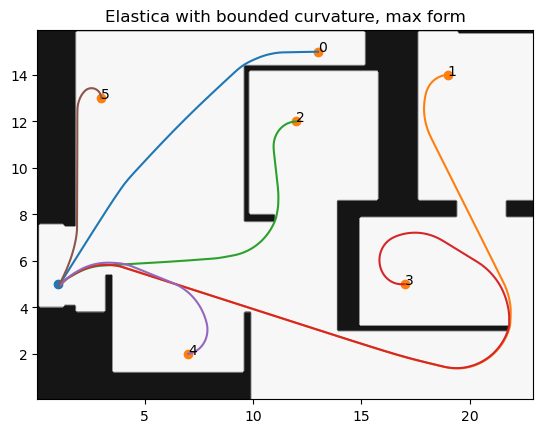

In [66]:
plt.title("Elastica with bounded curvature, max form")
plt.contourf(*X,walls,cmap='Greys')
plt.scatter(*sumIn['seed'][:2])
plt.scatter(*sumIn['tips'].T[:2])
for i,tip in enumerate(sumIn['tips']): plt.text(*tip[:2],f"{i}")
for geo in maxStateOut['geodesics']: plt.plot(*geo[:2])

The last coordinate represents the state, which in this model corresponds to the the turning radius. We can see how the state varies along the trajectory.

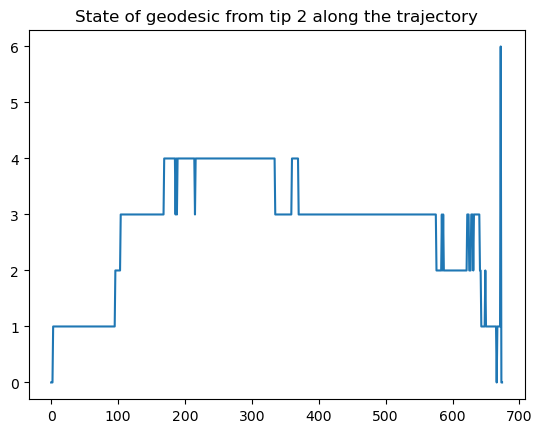

In [67]:
igeo=2;
plt.title(f"State of geodesic from tip {igeo} along the trajectory")
geo = maxStateOut['geodesics'][igeo]
plt.plot(geo[-1]);

The above discrete values are only a summary of the data. In the backtracking procedure, we actually use a mixed state, with a non-negative weight for each possibility. Such a mixed state appears to be unavoidable in order to have a reliable backtracking. 

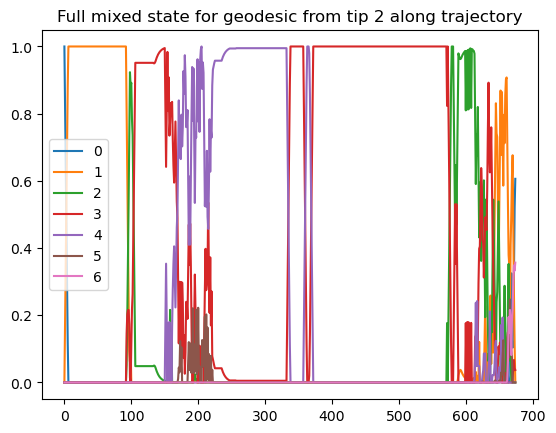

In [68]:
plt.title(f"Full mixed state for geodesic from tip {igeo} along trajectory")
geo_state = maxStateOut['geodesic_states'][2] # Full state data for geodesic number 2
for i,state_weight in enumerate(geo_state): plt.plot(state_weight,label=i)
plt.legend();

In [69]:
assert np.allclose(geo_state.sum(axis=0),1) # State weights sum to one
assert np.all(geo_state>=0) # State weights are non-negative

Along the backtracking, the mixed state evolution in the `nstates`-dimensional probability simplex is dictated a vector field `flow_state` computed similarly to the geodesic flow.

In [70]:
flow_state = maxStateOut['flow_state']
# Coordinates sum to zero, because total state proba = 1 is constant
assert np.allclose(np.sum(flow_state,axis=0),0,atol=1e-4) 

## 4. Penalization of curvature variation

We consider a four dimensional variant of the elastica model, posed on 
$$
    \bR^2_x \times \bS^1_\theta \times \bR_\kappa,
$$
whose metric reads
$$
    \cF_{x,\theta,\kappa}(\dot x, \dot \theta, \dot \kappa) = \dot s + \frac{\dot \kappa^2} {\dot s}, \qquad \text{ if } (\dot x,\dot \theta) = \dot s (\bn(\theta),\kappa), 
$$
for some $\dot s>0$. The metric equals $+\infty$ elsewhere, except at zero.

Consider a curve $\gamma$ with finite energy for this metric. Then the horizontal velocity $\dot x$ is non-vanishing, and we can therefore reparametrize it so that $|\dot x|=1$, with total planar Euclidean length $L$. The curve energy is thus : 
$$
\int_0^L \cF_{\gamma(t)}(\gamma'(t))\diff t = \int_0^L (1+\dot \kappa^2) \diff t
$$

The Hamiltonian admits an integral representation, which can be deduced from the representation of the original model, namely
$$
    \cH_p(\hat p) = \int_{-\pi/2}^{\pi/2} \<n_\kappa(\theta,\phi),\hat p\>_+^2 \cos \phi \diff \phi
$$
where $p=({x,\theta,\kappa})$, $\hat p = (\hat x,\hat \theta,\hat \kappa)$, and $\bn_\kappa(\theta,\phi) = (\cos \theta \cos \phi, \sin \theta \cos \phi, \kappa\cos \phi, \sin \phi)$.

**Disclaimer** This model is highly experimental.
This is a high order model, solved with a low order numerical method, which in addition uses wide stencils. As a result non-holonomic constraints seem to be often violated by the numerical method. 

In other words, there is a substantial amount of numerical diffusion, which results in trajectories violating the relation
$$
    (\dot x,\dot \theta) \propto (\bn(\theta), \kappa)
$$

In addition, the geodesic backtracking EDO solver often has issues, because the solution of the eikonal equation has strong singularities, in particular at the seed and near walls.

### 4.1 Generating the controls

In order to limit the computational cost, we use only few terms for the intergral discretization.

In [71]:
def embed4(c,θ,κ):
    """
    Embed a two dimensional control (α,β) in R^2 x R x R as (α n(θ),α κ, β)
    where n(θ) = (cos θ, sin θ)
    """
    ds,dθ = c
    uθ,uκ = np.ones_like(θ),np.ones_like(κ)
    return np.array((ds*np.cos(θ)*uκ,ds*np.sin(θ)*uκ,ds*uθ*κ,dθ*uθ*uκ))

As before, we can introduce some prior information in the metric, using the `with_prior` function.
However, it acts on the derivative of the curvature this time, rather than the curvature itself. 

More precisely, the model becomes:
$$
\int_0^L (1+(\xi(\dot \kappa-\kappa_0))^2) \diff t.
$$
Thus $\kappa_0$ is a reference curvature derivative (instead of a reference curvature previously), and $1/\xi$ is the typical magnitude of the curvature derivative (instead of the typical magnitude of curvature). 

### 4.2 Running the eikonal solver

The model considered in this section is four dimensional. In order to have a reasonable computational cost, we use a coarse discretization of the last dimension.

Note that, since we use a finite set of values to discretize the curvature, it is bounded by construction.

In [72]:
κmin = -1; κmax = 1; nκ = 9
aK,dκ = np.linspace(κmin,κmax,nκ,retstep=True)

In [73]:
aK,dκ

(array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ]), 0.25)

In [74]:
curvIn = Eikonal.dictIn({
    'model':'Custom4',
    'speed':1,
    'seed':(*elasticaIn['seed'],0),
    'tips':[(*tip,0) for tip in elasticaIn['tips']],
    'dims':(*elasticaIn['dims'],nκ),
    'origin':(0,0, -np.pi/Nθ,κmin-dκ/2),
    'gridScales':(*elasticaIn.gridScales,dκ),
    'periodic':[False,False,True,False], # Domain = R^2 x S^1 x R
    'exportValues':True,
})
curvIn['walls'] = np.broadcast_to(walls[:,:,np.newaxis,np.newaxis],curvIn.shape)

In [75]:
assert np.allclose(curvIn.Axes()[-1],aK) # Last axis correctly set

In [76]:
I=5
controls = with_prior(elastica_terms(I),ξ=2)
curvIn['controls'] = np.moveaxis(embed4(controls,Θ[:,np.newaxis,np.newaxis],aK[np.newaxis,:,np.newaxis]),-1,0)

Always check the controls shape, which must be : 
$$
    \text{number of controls} \times \text{physical space dimension} \times \text{last domain dimensions}.
$$

Here the domain has dimensions $N_x \times N_y\times N_\theta \times N_\kappa$. Only the last two domain dimensions are used in this example, namely $N_\theta\times N_\kappa$, since the control vectors do not depend on the physical coordinates $x$ and $y$.

In [77]:
curvIn['controls'].shape

(5, 4, 64, 9)

In [78]:
curvOut = curvIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 4.072147607803345 seconds, and 297 iterations.
Post-Processing


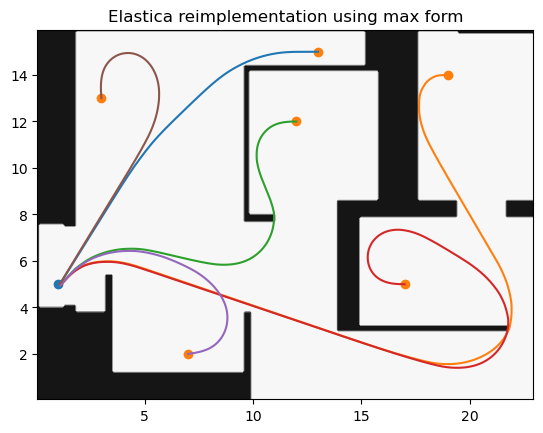

In [79]:
plt.title("Elastica reimplementation using max form")
plt.contourf(*X,walls,cmap='Greys')
plt.scatter(*sumIn['seed'][:2])
plt.scatter(*sumIn['tips'].T[:2]);
for geo in curvOut['geodesics']: plt.plot(*geo[:2])

Some qualitative properties of the above numerical results are coherent with the model:
- (Spiral sections) There are long curve sections where the curvature monotonically increases.
- (Straight segments) There are long (almost) straight sections. Indeed, the straight line is very stable, since deviating from it requires first modifying the curvature.

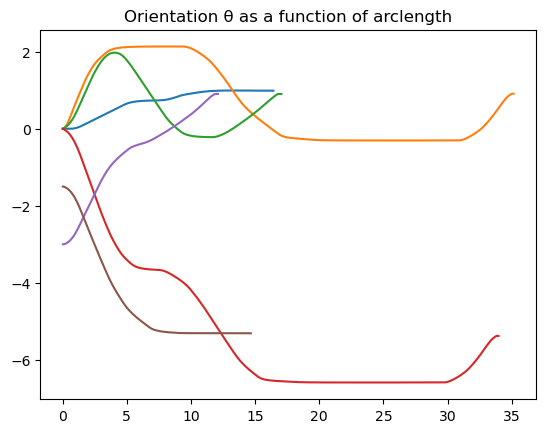

In [80]:
plt.title('Orientation θ as a function of arclength')
for geo in curvOut['geodesics']:
    arclen = np.cumsum(np.linalg.norm(geo[:2,1:]-geo[:2,:-1],axis=0))
    plt.plot(arclen,geo[2,1:])

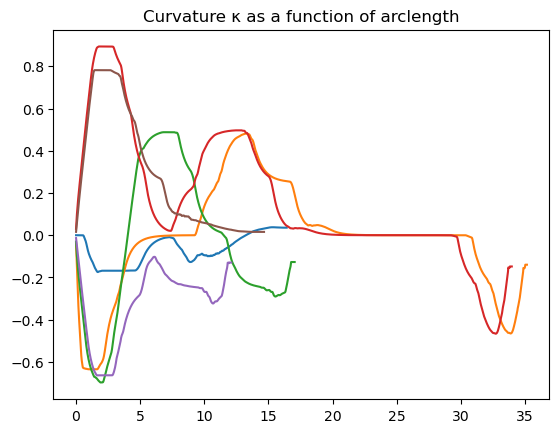

In [81]:
plt.title('Curvature κ as a function of arclength')
for geo in curvOut['geodesics']:
    arclen = np.cumsum(np.linalg.norm(geo[:2,1:]-geo[:2,:-1],axis=0))
    plt.plot(arclen,geo[3,1:])